In [315]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)
from skimage.segmentation import quickshift, slic, mark_boundaries

Notebook run using keras: 2.2.4


## Using Inception

Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [2]:
inet_model = inc_net.InceptionV3()

In [380]:
def transform_img(path_list):
    """ preprocess image to feed to the network """
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

## Let's see the top 5 prediction for some image

Let us upload some image, feed it to pretrained NN (here InceptionV3) and look at the top 5 predicted classes. Here we print "label #", which is the number further given to the LIME explainer.

label # 31, class: tree_frog , prob=0.9795
label # 32, class: tailed_frog , prob=0.0088
label # 30, class: bullfrog , prob=0.0004
label # 447, class: binoculars , prob=0.0001
label # 443, class: bib , prob=0.0001


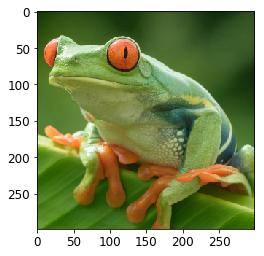

In [665]:
images = transform_img(['./frog.jpg'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
sorted_labels = np.argsort(-preds[0])
for label,x in zip(sorted_labels, decode_predictions(preds, top=5)[0]):
    print('label # %s,' % label, 'class:', x[1], ', prob=%.4f' % x[2])

## Explanation with lime

In [631]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [632]:
import lime_sk
import image_processing2

Here we need to choose class we want to explain. Fix the label number according to the above output.

In [633]:
label = 31

We are free to choose the kernel_width, which is used in weighted loss to estimate weights for the newly generated samples. 

In [634]:
explainer_lime_sk = image_processing2.ImageExplainer(label=label, kernel_width=0.5, random_state=42)

In [635]:
%%time
explanation_lime_slic = explainer_lime_sk.explain_prediction(images[0], inet_model.predict, 
                                                             num_samples=1000, 
                                                             segmentation='slic')

CPU times: user 14min 36s, sys: 2min 24s, total: 17min 1s
Wall time: 5min 29s


In [636]:
explanation_lime_slic.score

0.3149414601460351

In [671]:
total_number_of_features = np.unique(explanation_lime_slic.segments).shape[0]
total_number_of_features

85

## Now let's see the explanation for the top class (tree frog)

In [666]:
explanation = explanation_lime_slic

Here we plot 30 most important contributions, removing all other superpixels from image.

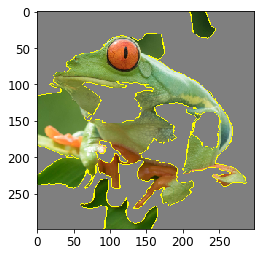

In [667]:
temp, mask = explanation.get_image_and_mask(positive_only=True, num_features=30, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
lost_frog = images[0] - temp
# plt.imshow(lost_frog / 2 + 0.5)

Let us check the prediction of Inception on this 30 superpixels.

label # 31, class: tree_frog , prob=0.9287
label # 32, class: tailed_frog , prob=0.0129
label # 47, class: African_chameleon , prob=0.0026
label # 611, class: jigsaw_puzzle , prob=0.0011
label # 30, class: bullfrog , prob=0.0010


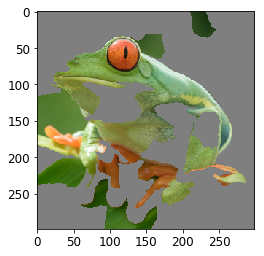

In [669]:
plt.imshow(temp / 2 + 0.5)
preds = inet_model.predict(temp[np.newaxis, :])
sorted_labels = np.argsort(-preds[0])
for label,x in zip(sorted_labels, decode_predictions(preds, top=5)[0]):
    print('label # %s,' % label, 'class:', x[1], ', prob=%.4f' % x[2])

Now let's remove them and check the Inception prediction for the obtained image.

label # 988, class: acorn , prob=0.1408
label # 31, class: tree_frog , prob=0.0798
label # 40, class: American_chameleon , prob=0.0199
label # 46, class: green_lizard , prob=0.0166
label # 113, class: snail , prob=0.0132


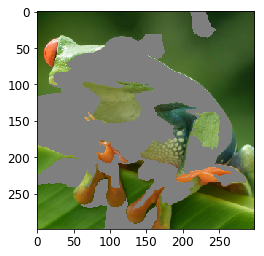

In [670]:
plt.imshow(lost_frog / 2 + 0.5)
preds = inet_model.predict(lost_frog[np.newaxis, :])
sorted_labels = np.argsort(-preds[0])
for label,x in zip(sorted_labels, decode_predictions(preds, top=5)[0]):
    print('label # %s,' % label, 'class:', x[1], ', prob=%.4f' % x[2])